# Model Evaluation
The following notebook performs measures various metrics involving the models against the provided ground-truth data.
This notebook is meant to be used as a prototype workbench for developing core code for model performance evaluation and comparison.

In our evaluation pipeline, we closely follow the result analysis performed by Gabere et. al.

In [1]:
import math
import numpy as np
import seaborn as sns
import modin.pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:30539 to respond...
Waiting for redis server at 127.0.0.1:33061 to respond...
Starting the Plasma object store with 6.00 GB memory.


In [15]:
# Application Hyperparameters
DATA_ROOT = '../data/out/data.fasta.txt/'
SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CAMPR3-ANN', 'CAMPR3-DA', 'CAMPR3-RF', 'CAMPR3-SVM']
DATASET = ['A', 'D'] # A for AMP3 and D for DAMPD

## Load Dataset

In [16]:
data = {}
for s in SERVERS:
    data[s] = {}
    for d in DATASET:
        data[s][d] = pd.read_csv(DATA_ROOT + s + '.csv')
        data[s][d] = data[s][d][data[s][d]['PepID'].str.contains(d)]
        print(s + ' ['+d+']' + ' : ' + str(data[s][d].size) + ' RECORDS')

ADAM_HMM [A] : 61668 RECORDS
ADAM_HMM [D] : 19686 RECORDS
ADAM_SVM [A] : 61668 RECORDS
ADAM_SVM [D] : 19686 RECORDS
AMPA [A] : 61668 RECORDS
AMPA [D] : 19686 RECORDS
CAMPR3-ANN [A] : 61668 RECORDS
CAMPR3-ANN [D] : 19686 RECORDS
CAMPR3-DA [A] : 61668 RECORDS
CAMPR3-DA [D] : 19686 RECORDS
CAMPR3-RF [A] : 61668 RECORDS
CAMPR3-RF [D] : 19686 RECORDS
CAMPR3-SVM [A] : 61668 RECORDS
CAMPR3-SVM [D] : 19686 RECORDS


In [17]:
# Filter -999 Values
for s in SERVERS:
    for d in DATASET:
        pre_filter = data[s][d].size
        data[s][d] = data[s][d].query('PredLabel != -999')
        print(s + ' ['+d+']' + ' (POST-FILTERED): ' + str(data[s][d].size) + ' RECORDS ' + '('+ str(pre_filter - data[s][d].size) +' FILTERED)')

/usr/local/lib/python3.6/dist-packages/modin/pandas/dataframe.py:2901: UserWarning: User-defined function verification with DataFrame dtypes is still under development. Should be fully functional in a future release.
  UserWarning,


ADAM_HMM [A] (POST-FILTERED): 61656 RECORDS (12 FILTERED)
ADAM_HMM [D] (POST-FILTERED): 19536 RECORDS (150 FILTERED)
ADAM_SVM [A] (POST-FILTERED): 61644 RECORDS (24 FILTERED)
ADAM_SVM [D] (POST-FILTERED): 19500 RECORDS (186 FILTERED)
AMPA [A] (POST-FILTERED): 61482 RECORDS (186 FILTERED)
AMPA [D] (POST-FILTERED): 19656 RECORDS (30 FILTERED)
CAMPR3-ANN [A] (POST-FILTERED): 61656 RECORDS (12 FILTERED)
CAMPR3-ANN [D] (POST-FILTERED): 19584 RECORDS (102 FILTERED)
CAMPR3-DA [A] (POST-FILTERED): 61656 RECORDS (12 FILTERED)
CAMPR3-DA [D] (POST-FILTERED): 19584 RECORDS (102 FILTERED)
CAMPR3-RF [A] (POST-FILTERED): 61656 RECORDS (12 FILTERED)
CAMPR3-RF [D] (POST-FILTERED): 19398 RECORDS (288 FILTERED)
CAMPR3-SVM [A] (POST-FILTERED): 61656 RECORDS (12 FILTERED)
CAMPR3-SVM [D] (POST-FILTERED): 19584 RECORDS (102 FILTERED)


## Threshold Based Metrics

### Confusion Matrix

In [19]:
for s in SERVERS:
    for d in DATASET:
        print('[' + s + ' ['+d+']' + ']')
        con_mat = confusion_matrix(data[s][d]['AMPLabel'], data[s][d]['PredLabel'])
        print(str(con_mat) + '\n')
        print('True Positive:\t' + str(con_mat[0][0]))
        print('False Positive:\t' + str(con_mat[0][1]))
        print('False Negative:\t' + str(con_mat[1][0]))
        print('True Negative:\t' + str(con_mat[1][1]))
        print('='* 40)

[ADAM_HMM [A]]
[[5309 3254]
 [ 155 1558]]

True Positive:	5309
False Positive:	3254
False Negative:	155
True Negative:	1558
[ADAM_HMM [D]]
[[1916  809]
 [ 114  417]]

True Positive:	1916
False Positive:	809
False Negative:	114
True Negative:	417
[ADAM_SVM [A]]
[[5308 3253]
 [ 155 1558]]

True Positive:	5308
False Positive:	3253
False Negative:	155
True Negative:	1558
[ADAM_SVM [D]]
[[1892  826]
 [ 115  417]]

True Positive:	1892
False Positive:	826
False Negative:	115
True Negative:	417
[AMPA [A]]
[[7728  820]
 [1093  606]]

True Positive:	7728
False Positive:	820
False Negative:	1093
True Negative:	606
[AMPA [D]]
[[2321  409]
 [ 292  254]]

True Positive:	2321
False Positive:	409
False Negative:	292
True Negative:	254
[CAMPR3-ANN [A]]
[[7138 1425]
 [ 286 1427]]

True Positive:	7138
False Positive:	1425
False Negative:	286
True Negative:	1427
[CAMPR3-ANN [D]]
[[2207  521]
 [ 107  429]]

True Positive:	2207
False Positive:	521
False Negative:	107
True Negative:	429
[CAMPR3-DA [A]]
[[695

In [20]:
print('Classification Report')

for s in SERVERS:
    for d in DATASET:
        print('['+s + ' ['+d+']'+']')
        print(classification_report(data[s][d]['AMPLabel'], data[s][d]['PredLabel'], [0, 1]))
        print('='*40)

Classification Report
[ADAM_HMM [A]]
              precision    recall  f1-score   support

           0       0.97      0.62      0.76      8563
           1       0.32      0.91      0.48      1713

   micro avg       0.67      0.67      0.67     10276
   macro avg       0.65      0.76      0.62     10276
weighted avg       0.86      0.67      0.71     10276

[ADAM_HMM [D]]
              precision    recall  f1-score   support

           0       0.94      0.70      0.81      2725
           1       0.34      0.79      0.47       531

   micro avg       0.72      0.72      0.72      3256
   macro avg       0.64      0.74      0.64      3256
weighted avg       0.85      0.72      0.75      3256

[ADAM_SVM [A]]
              precision    recall  f1-score   support

           0       0.97      0.62      0.76      8561
           1       0.32      0.91      0.48      1713

   micro avg       0.67      0.67      0.67     10274
   macro avg       0.65      0.76      0.62     10274
weighte

### ROC/AUC Curve

#### Total ROC/AUC Score

In [21]:
for s in SERVERS:
    for d in DATASET:
        print(s + ' ['+d+']' + ' SCORE:\t'+str(roc_auc_score(data[s][d]['AMPLabel'], data[s][d]['PredScore'])))

ADAM_HMM [A] SCORE:	0.7647542315228382
ADAM_HMM [D] SCORE:	0.7442150002591613
ADAM_SVM [A] SCORE:	0.7647682477584545
ADAM_SVM [D] SCORE:	0.7399673300248413
AMPA [A] SCORE:	0.6344937689405781
AMPA [D] SCORE:	0.6690110560989683
CAMPR3-ANN [A] SCORE:	0.8333139038365348
CAMPR3-ANN [D] SCORE:	0.8046953648181381
CAMPR3-DA [A] SCORE:	0.9069242908864276
CAMPR3-DA [D] SCORE:	0.8127848431960433
CAMPR3-RF [A] SCORE:	0.9527582352263049
CAMPR3-RF [D] SCORE:	0.901635108661365
CAMPR3-SVM [A] SCORE:	0.920187547137834
CAMPR3-SVM [D] SCORE:	0.8289959431216352


In [23]:
# Plot ROC/AUC
def plot_roc(name, d):
    plt.title(name + ' ROC')
    for s in SERVERS:
        fpr, tpr, threshold = roc_curve(data[s][d]['AMPLabel'], data[s][d]['PredScore'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = s + ': %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

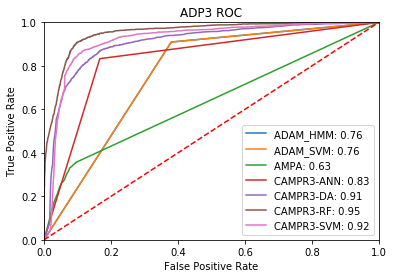

In [24]:
plot_roc('ADP3', 'A')

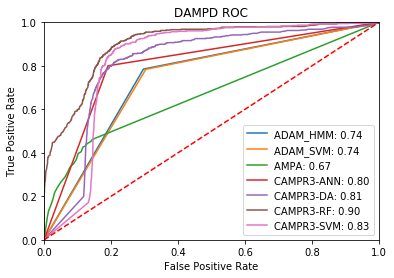

In [25]:
plot_roc('DAMPD', 'D')

## Feature Dependence Analysis

### Length vs Prediction Probability

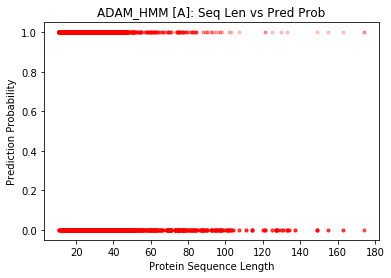

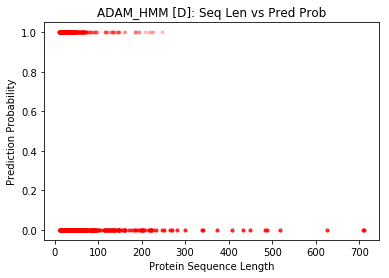

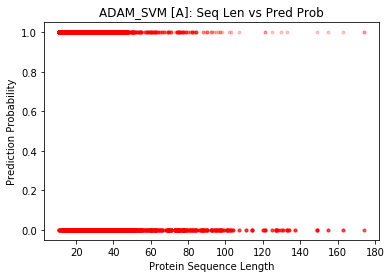

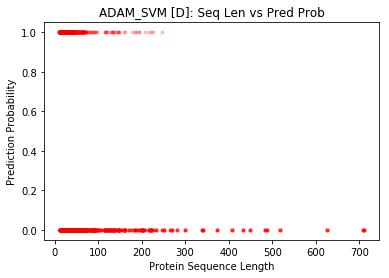

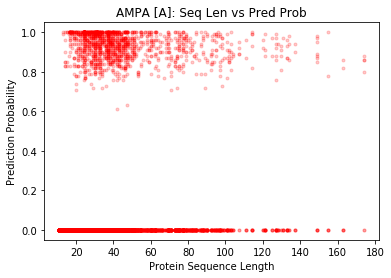

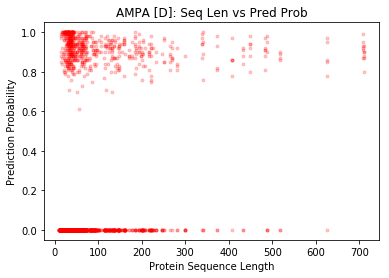

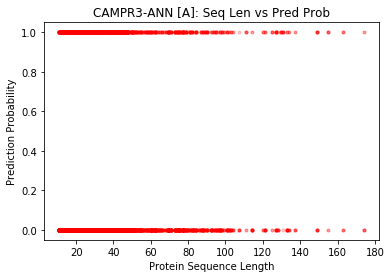

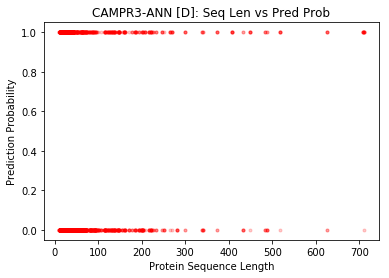

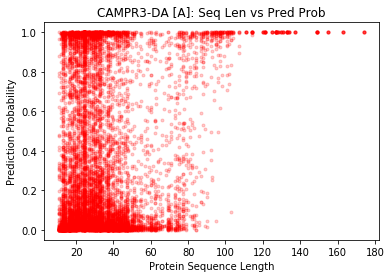

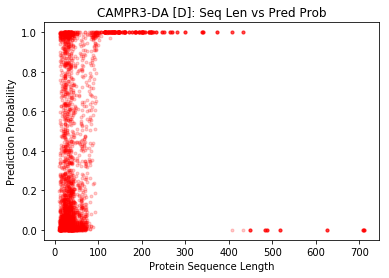

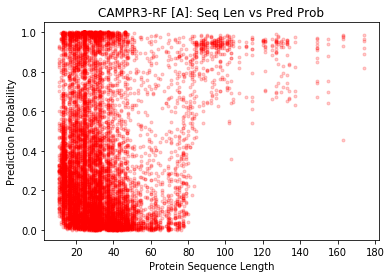

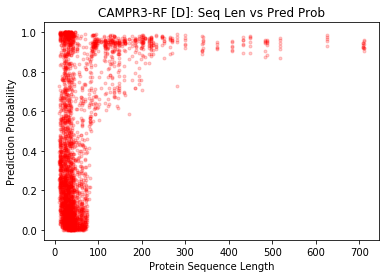

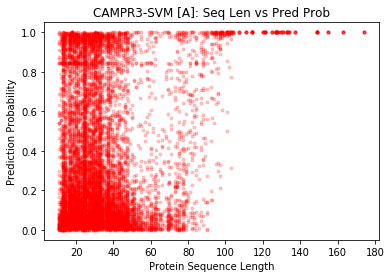

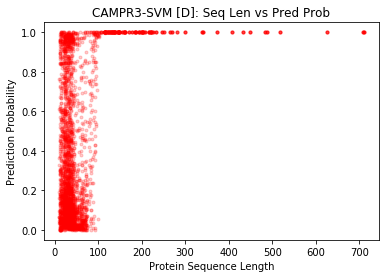

In [29]:
for s in SERVERS:
    for d in DATASET:
        plt.title(s + ' ['+d+']' + ': Seq Len vs Pred Prob')
        plt.plot(data[s][d]['PepSeq'].apply(len), data[s][d]['PredScore'], 'r.', alpha=0.2)
        plt.xlabel('Protein Sequence Length')
        plt.ylabel('Prediction Probability')
        plt.show()

### Number of Unique Protein Count vs Prediction Probability

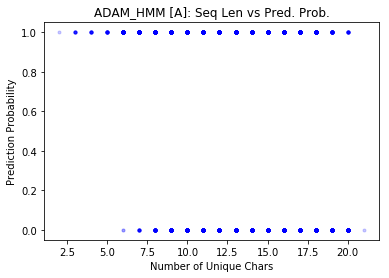

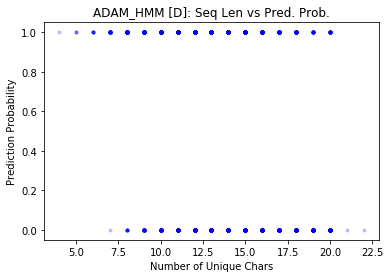

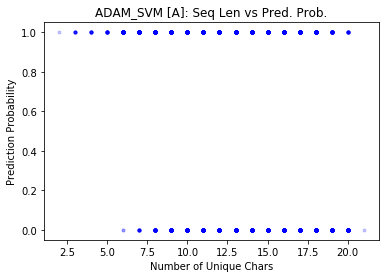

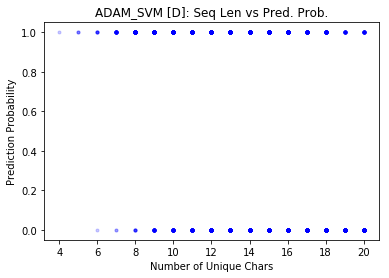

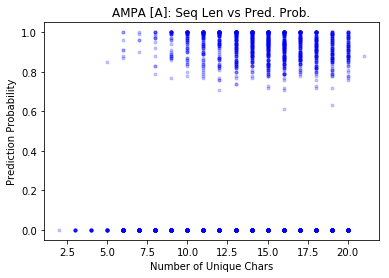

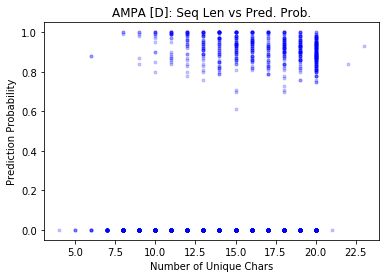

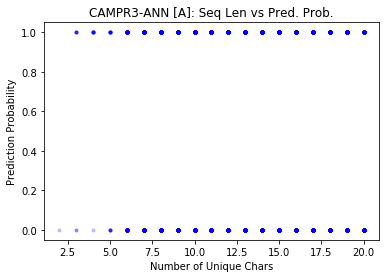

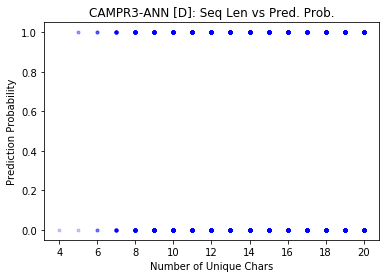

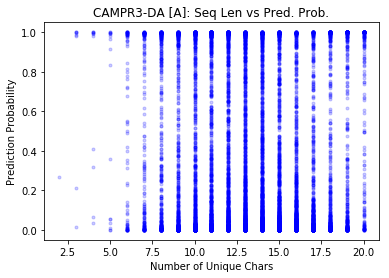

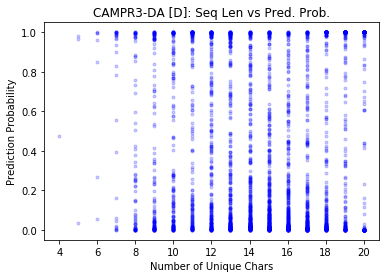

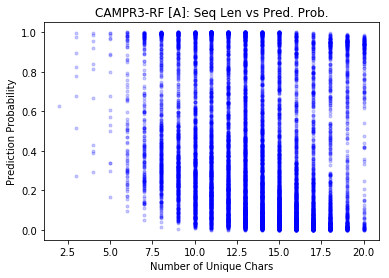

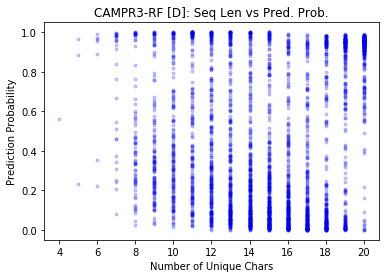

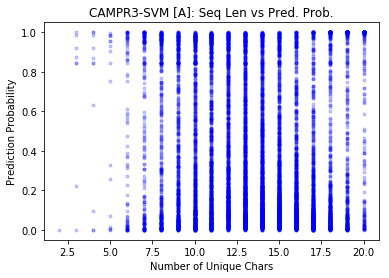

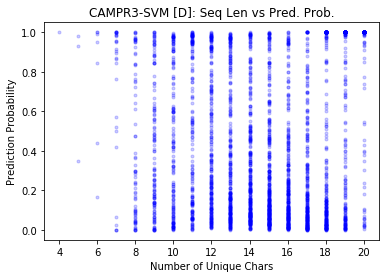

In [28]:
for s in SERVERS:
    for d in DATASET:
        plt.title(s + ' ['+d+']' + ': Seq Len vs Pred. Prob.')
        plt.plot(data[s][d]['PepSeq'].apply(lambda x: len(set(x))), data[s][d]['PredScore'], 'b.', alpha=0.2)
        plt.xlabel('Number of Unique Chars')
        plt.ylabel('Prediction Probability')
        plt.show()